In [9]:
from arg_utils import is_notebook, get_cfg
cfg = get_cfg()
# choices
classical_models = ["linear", "xgb", "rf"]
nn_models = ["mlp", "rnn", "clip", "gpt"]
# override variables to experiment in notebook
if is_notebook():    
    cfg["outer_folds"] = 0
    cfg["target_name"] = "ICP_Vital"   # ICP_Vital" , long_icp_hypertension_2
    cfg["db_name"] = "UKE"  # "UKE", "MIMIC", "eICU"
    cfg["minutes"] = 60
    cfg["model_type"] = "rnn"
    cfg["gpt_name"] = "gpt2"  # distilgpt2, gpt2, gpt2-medium, gpt2-large(too large)
    cfg["reduction_factor"] = 16
    
    cfg["randomly_mask_aug"] = 0.04

    # do experiments on:  fill_type, target_nan_quantile, train_noise_std, 
    #  min_len(increase from 20 to higher), grad_clip_val (at 1 so far), weight_decay (at 0.2 so far)
    
    cfg["fill_type"] = "none" # "pat_mean", "median", "pat_ema" "pat_ema_mask"
    #cfg["norm_method"] = None # z, or none
    
    cfg["bs"] = 64 # 8 best for rnn, 32 for GPT
    #length = 128
    #cfg["max_len"] = length
    #cfg["min_len"] = length
    #cfg["max_len"] = 512 #cfg["block_size"] # 720

    # classical model args
    cfg["flat_block_size"] = 1
    # general args
    cfg["max_epochs"] = 20
    cfg["use_nan_embed"] = True
    cfg["norm_nan_embed"] = True
    cfg["weight_decay"] = 0.2
    cfg["grad_clip_val"] = 1.0
    cfg["use_huber"] = 0
    
    cfg["lr"] = 0.001

    # rnn params
    cfg["hidden_size"] = 2048
    cfg["rnn_type"] = "gru"

    cfg["rnn_layers"] = 1
    
    # transformer stats for gpt2
    # 4.338-4.8GB with adapters and batch size 16 and 117 secs
    # 6.620GB with adapters and batch size 32 and only 100 secs
    # 11.074 GB with adapters and batch size 64 and 92 secs
    # also 4.864GB with train_mlp_norm and 127 secss
    # all get to r2 of around 0.48

    # transformer stats for gptneo1.3
    # bs8 2.1GB, 

    # rnn stats for hidden layers size 2048
    # bs 64, 5084MB, 40 secs.
    # bs 128, 8632MB, 38 secs.

    # transformer params
    cfg["mode"] = "adapters"  # "adapters", "train_mlp_norm",  "train_norm", "freeze" (does not train)
    cfg["gpu"] = 1
    
    cfg["seed"] = 0
    cfg["subsample"] = 0.9
    cfg["colsample_bytree"] = 0.9
    
    cfg["target_nan_quantile"] = 0.9999
    
    
# overrides and calculated default vals
if cfg["lr"] is None:
    model_type = cfg["model_type"]
    if model_type == "clip":
        cfg["lr"] = 0.001
    elif model_type == "gpt":
        # bs 8 and gpt2 take 9.8GB with max seq len of 512
        # bs 16 with max seq len of 256
        # bs 32 with max seq len 128 only 7.4GB, good performance and fast - 6.9 if mlp_norm
        # bs 64 with len 128 and mlp_norm = 10.9GB. 9.4GB for freeze
        cfg["lr"] = 0.00005
    else:
        cfg["lr"] = 0.0001  # 0.01 works kind of for nan_embed

if cfg["fill_type"] == "none":
    cfg["use_nan_embed"] = 1
        
#cfg["val_check_interval"] = int(cfg["val_check_interval"] * (32 / cfg["batch_size"]))
    
import pytorch_lightning as pl
pl.utilities.seed.seed_everything(seed=cfg["seed"], workers=False)
locals().update(cfg)

In [10]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = str(cfg["gpu"])

import torch
import pytorch_lightning as pl
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

import logging
import pytorch_lightning
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
pytorch_lightning.utilities.distributed.log.setLevel(logging.ERROR)

In [11]:
# load df
path = f'data/DB_{cfg["db_name"]}_{cfg["minutes"]}_final_df.parquet'
df = pd.read_parquet(path)
print(df.shape)
# drop columns that are completely NaN
df = df.dropna(axis=1, how="all")
print(df.shape)
# drop columns that are completely zero
mean_zeros = (df == 0).mean()
df = df[list(mean_zeros[mean_zeros < 1.0].index)]
#df = df[((df == 0).mean() < 0.9999).index]
print(df.shape)

(289534, 201)
(289534, 185)
(289534, 98)


In [12]:
#df.to_parquet(path)

In [4]:
print(len(df))
print(df["ICP_Vital"].describe())
print(df.isna().mean().mean())
print(df["ICP_Vital"].isna().mean())

158406
count    132555.000000
mean         10.912355
std           8.251908
min         -41.000000
25%           6.000000
50%          10.000000
75%          14.000000
max         350.000000
Name: ICP_Vital, dtype: float64
0.46815284890399506
0.1631945759630317


In [5]:
# create datamodule with dataloaders

from train_utils import make_train_val_fold

dms = make_train_val_fold(df, cfg, cfg["outer_folds"])
dm = dms[0]

In [6]:
# print quantiles
train_ds = dm.train_ds
print("NaN quantiles:", train_ds.lower_target_nan_quantile, train_ds.upper_target_nan_quantile)
print("Clip quantiles:", train_ds.lower_target_clip_quantile, train_ds.upper_target_clip_quantile)

NaN quantiles: -29.907400000002767 129.80859999981476
Clip quantiles: -9.0 85.0


In [7]:
# test dataloader
out = next(iter(dm.train_dataloader()))
inputs, targets, lens = next(iter(dm.train_dataloader()))
#print(dm.feature_names)
print(inputs.shape, inputs.min(), inputs.max())
print(targets.shape)
print(targets[~torch.isnan(targets)].mean())
print(lens)
print(lens.float().mean(), lens.max())
# TODO: lens max and mean deviate strongly from each other - smaller ranges, increase min_len

torch.Size([64, 128, 96]) tensor(nan) tensor(nan)
torch.Size([64, 128, 1])
tensor(-0.0302)
tensor([ 12,  92,  72,  48,  25,  87, 104, 122, 128,   4,   8,  41, 128, 128,
         22, 128, 128,  13, 128, 128,  11,  85, 128,  89, 128, 113, 128, 128,
         14, 128, 109,  88,  76,   9,  18,  27, 128, 124,  94, 128, 128, 128,
        128, 119, 128, 106, 128, 128,  91,  70,  80, 128, 128,   9, 128, 128,
        128,  36,  19,  11, 128, 128, 128,  96])
tensor(89.5000) tensor(128)


In [8]:
# train model on datamodule
from train_utils import train_model

models, trainers = train_model(cfg["model_type"], dms, cfg, verbose=True)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Number of trainable parameters:  24708097


wandb: Currently logged in as: antonius. Use `wandb login --relogin` to force relogin


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
/home/anton/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:107: UserWarning: attribute 'data_module' removed from hparams because it cannot be pickled
  rank_zero_warn(f"attribute '{k}' removed from hparams because it cannot be pickled")


Sanity Checking: 0it [00:00, ?it/s]

/home/anton/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [9]:
torch.cuda.empty_cache()
import gc
gc.collect()

921

In [10]:
import eval_utils
from eval_utils import get_all_dfs, print_all_metrics
import importlib
importlib.reload(eval_utils)
# eval
dl_type = "test"
#dl = external_dls["MIMIC"] # external_dls - MIMIC, eICU, UKE
calc_new_norm_stats = False
dl = None

pred_df = get_all_dfs(models, trainers, cfg["model_type"], dm.regression, dl_type=dl_type,
                      dl=dl, calc_new_norm_stats=calc_new_norm_stats)

11.054998274495961


In [11]:
import importlib

import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import eval_utils
importlib.reload(eval_utils)
from eval_utils import get_all_dfs, hypertension_acc, hypertension_auc


if dm.regression:
    #from eval_utils import hypertension_acc
    pred_targets = pred_df["targets"].dropna()
    preds = pred_df["preds"][~pred_df["targets"].isna()]
    print("Baseline acc for hypertension: ", hypertension_acc(pred_targets, np.zeros((len(pred_targets,)))))
    print("Accuracy for hypertension: ", hypertension_acc(pred_targets, preds))
    print("AUC for hypertension: ", hypertension_auc(pred_targets, preds))

    print_all_metrics(pred_df)
else:
    # general metrics
    non_na_pred_df = pred_df.dropna(subset=["targets"])
    binary_preds = non_na_pred_df["preds"] > 0.5
    targets = non_na_pred_df["targets"] 
    preds = non_na_pred_df["preds"]
    
    
    auc = sklearn.metrics.roc_auc_score(targets, preds)
    tpr, fpr, threshs = sklearn.metrics.roc_curve(targets, preds)
    plt.plot(tpr, fpr)
    plt.plot([0, 1], [0, 1], linestyle="--", color="black")
    plt.show()
    
    precision, recall, thresholds = sklearn.metrics.precision_recall_curve(targets, preds)
    plt.plot(precision, recall)
    plt.xlabel("precision")
    plt.ylabel("recall")
    plt.show()
    
    matrix = sklearn.metrics.confusion_matrix(non_na_pred_df["targets"],
                                              binary_preds)
    cm_display = sklearn.metrics.ConfusionMatrixDisplay(matrix).plot()
    print(matrix)
    print("AUC: ", auc)
    print("Mean pred: ", pred_df["preds"].mean())
    
    #train_pred_df = get_all_dfs(models, trainers, cfg["model_type"], dm.regression, dl_type="train", dl=None, calc_new_norm_stats=False)
    #non_na_df = train_pred_df.dropna(subset=["targets"])
    #tpr, fpr, threshs = sklearn.metrics.roc_curve(non_na_df["targets"], non_na_df["preds"])
    

Baseline acc for hypertension:  0.9884207251736892
Accuracy for hypertension:  0.9777747053333794
AUC for hypertension:  0.7066052448625525
Performance over splits: 
          targets     preds     error
model_id                             
0        -0.33412  0.257353  0.921617
Mean train target:  11.054998274495958
Mean/Std preds:  0.1975687944536083 5.536968305028041
Mean/Std targets:  -0.3341200812237719 7.596654755782659
Max error:  1402.766
Accuracy for hypertension baseline:  0.9884207251736892

Model metrics:
RMSE:  0.9600088
MSE:  0.92161685
MAE:  4.977210928973503
MAPE:  -14.896473479665206
R2 custom:  0.9840294217847549
R2 macro:  -0.6959466201018303
R2:  -0.17190485092899066
R2 old:  -0.17190485092899066
Accuracy for hypertension:  0.9777747053333794
Precision for hypertension:  0.09259259259259259
Recall for hypertension:  0.1044776119402985

Mean train baseline metrics:
Mean train target: 11.054998274495958
RMSE:  13.690112697926985
MSE:  187.41918568194166
MAE:  12.33018

In [12]:
from eval_utils import r2_score
df_nona = pred_df.dropna(subset=["targets"]).reset_index()
# macro R2
df_nona.groupby("ids").apply(lambda pat: r2_score(pat["targets"], pat["preds"], baseline_target=dm.preprocessor.mean_train_target)).mean()

0.071296988512939

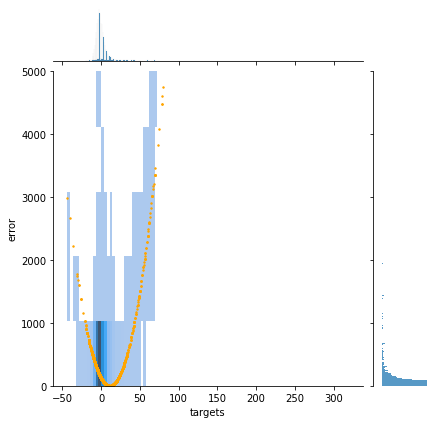

In [13]:
if dm.regression:
    df_nona = pred_df.dropna(subset=["targets"]).reset_index()
    mean_pred_error = (df_nona["targets"] - dm.preprocessor.mean_train_target).dropna() ** 2
    error = (df_nona["targets"] - df_nona["preds"]) ** 2
    df_nona["error"] = error
    ax = sns.jointplot(x="targets", y="error", data=df_nona, kind="hist", bins=100) # data=by_pat
    ax.ax_joint.scatter(df_nona["targets"], (np.ones(len(df_nona["targets"])) * dm.preprocessor.mean_train_target - df_nona["targets"]) ** 2, s=2, color="orange")
    plt.xlim(-20, 105)
    plt.ylim(0, 5000)

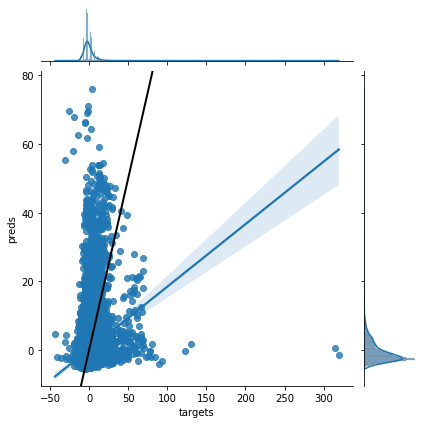

In [14]:
if dm.regression:
    ylim = (df_nona["preds"].min() - 5, df_nona["preds"].max() + 5)
    ax = sns.jointplot(data=df_nona, x="targets", y="preds", kind="reg", ylim=ylim) # data=bypat
    min_val = df_nona["targets"].min()
    max_val = df_nona["targets"].max()
    ax.ax_joint.plot([min_val, max_val], [min_val, max_val], linewidth=2, color="black", label="Ideal model")

-43.554998826737666 319.4450127729529


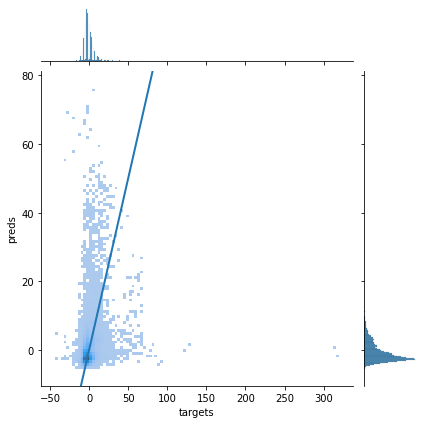

In [15]:
if dm.regression:
    ax = sns.jointplot(data=df_nona, x="targets", y="preds", kind="hist", bins=100, ylim=ylim)
    print(min_val, max_val)
    # draw line of perfect correlation
    ax.ax_joint.plot([min_val, max_val], [min_val, max_val], linewidth=2)#, color="black")

In [16]:
if dm.regression:
    #pats = df.groupby("ids").filter(lambda x: x['preds'].max() > 16)
    pats = pred_df.groupby("ids").filter(lambda x: x['targets'].mean() > 20)
    #pats = df.groupby("ids").filter(lambda x: np.sqrt(x['error'].mean()) > 30)
else:
    pats = pred_df.groupby("ids").filter(lambda x: x['preds'].mean() > 0.2)
pats = pats.groupby("ids").filter(lambda x: len(x["targets"].dropna()) > 2)

ids = pats["ids"].unique()
print(ids)
print(len(ids), "patients")
#pats

[ 28.  29.  46.  47.  54.  81.  99. 152.]
8 patients


mean average target:  11.054998274495958
mean pat targets:  20.64870564331346
R2 of model:  -2.1621958115815345
RMSE of model: 17.47
RMSE of mean: 13.73
MAPE of model:  0.7
MAPE of mean:  0.52


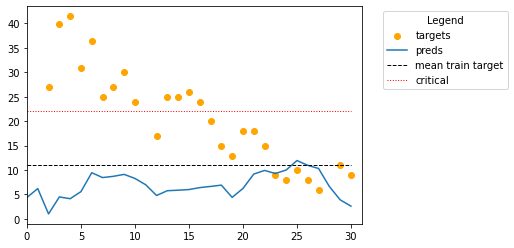

In [17]:
from eval_utils import mape
import sklearn

pat_id = 1
model_id = 0

pat = pred_df[pred_df["ids"] == ids[pat_id]]
pat = pat[pat["model_id"] == model_id]
plt.scatter(pat["step"], pat["targets"], label="targets", color="orange")
plt.plot(pat["step"], pat["preds"], label="preds")
mean = dm.preprocessor.mean_train_target
print("mean average target: ", mean)
print("mean pat targets: ", pat["targets"].mean())
plt.plot([0, max(pat["step"])], [mean, mean], linewidth=1, color="black", label="mean train target", linestyle="--")
plt.plot([0, max(pat["step"])], [22, 22], linewidth=1, color="red", label="critical", linestyle=":")

#plt.legend(location="out")
plt.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlim(0, max(pat["step"]) + 1)
pat_nona = pat[~pat["targets"].isna()]
print("R2 of model: ", sklearn.metrics.r2_score(pat_nona["targets"], pat_nona["preds"]))
print("RMSE of model:", round(np.sqrt(sklearn.metrics.mean_squared_error(pat_nona["targets"], pat_nona["preds"])), 2))
print("RMSE of mean:", round(np.sqrt(sklearn.metrics.mean_squared_error(pat_nona["targets"], [mean] * len(pat_nona))), 2))
print("MAPE of model: ", round(mape(pat_nona["targets"], pat_nona["preds"]), 2))
print("MAPE of mean: ", round(mape(pat_nona["targets"], [mean] * len(pat_nona)), 2))

In [18]:
#for i in range(len(dm.train_ds.targets)):
#    d = dm.train_ds.targets[i]
#    d = d[~torch.isnan(d)].max()
#    print(d)

## Saliency

In [19]:
feature_names = dm.feature_names

In [20]:
import shap


def classical_saliency(models, trainers, model_type, use_shap=False, verbose=True):
    # plot feature importance
    all_importances = []
    all_inputs = []
    
    for model, data_module in zip(models, trainers):
        if use_shap:
            explainer = shap.TreeExplainer(model)
            inputs = data_module.test_dataloader().dataset.flat_inputs
            importances = explainer.shap_values(inputs)
            all_inputs.append(inputs)
        else:
            if hasattr(model, "feature_importances_"):
                importances = model.feature_importances_
            elif hasattr(model, "coef_"):
                importances = model.coef_
        all_importances.append(importances)
    if not use_shap and verbose and hasattr(model, "importance_type"):
        print("Importance type: ", model.importance_type)
    print("importances shape ", importances.shape)
    mean_importances = np.mean(np.stack(all_importances), axis=0)
    # save
    path = f"outputs/{model_type}"
    os.makedirs("outputs", exist_ok=True)
    
    block_size = cfg["flat_block_size"]

    
    if use_shap:
        #shap.summary_plot(mean_importances, X_test, plot_type="bar")
        #shap.summary_plot(mean_importances, X_test)
        #shap.summary_plot(mean_importances)
        #input_df = pd.DataFrame(inputs, columns=feature_names)
        #shap_df = pd.DataFrame(mean_importances, columns=feature_names)
        
        #vals= np.abs(shap_values).mean(0)
        #feature_importance = pd.DataFrame(list(zip(feature_names, vals)),columns=['col_name','feature_importance_vals'])
        #feature_importance = feature_importance.sort_values(by=['feature_importance_vals'], ascending=False)
        #feature_importance.head()
                
        if verbose:
            block_feat_names = []
            for i in range(block_size):
                block_feat_names.extend([f + f"_{i}" for f in feature_names])
            
            shap.summary_plot(mean_importances, features=inputs, 
                              feature_names=block_feat_names)
            plt.savefig(path + "_shap_importances.jpg", bbox_inches='tight')
        
        
        # average over block_size/time_steps
       
        if block_size > 1:
            print(mean_importances.shape)
            mean_importances = mean_importances.reshape(-1, len(feature_names), block_size).mean(axis=-1)
            print(mean_importances.shape)


        imp_per_feat = np.abs(mean_importances).mean(axis=0)
        feat_df = pd.Series(imp_per_feat, index=feature_names)
    else:
        # make plot
        if block_size > 1:
            print(mean_importances.shape)
            mean_importances = np.abs(mean_importances.reshape(len(feature_names), block_size)).mean(axis=-1)
            print(mean_importances.shape)
        
        
        feat_df = pd.Series(mean_importances, index=feature_names)
        if verbose:
            p = feat_df.sort_values().plot.barh(figsize=(4, 25))
            p.figure.savefig(path + "_importances.jpg", bbox_inches='tight')
        
    feat_df = feat_df.sort_values(ascending=True)
    return feat_df


def reduce_feat_df(feat_df, threshold=0.2):
    # remove everything above 90% explained importance
    print(len(feat_df))
    feat_df = feat_df / feat_df.sum()
    reduced_df = feat_df[feat_df.cumsum() > threshold]
    print(len(reduced_df))
    print(reduced_df.sum())
    print(reduced_df)
    reduced_feats = list(reduced_df.index)
    return reduced_feats


In [21]:
if cfg["model_type"] in ["xgb", "log"]:
    sal_df = classical_saliency(models, trainers, cfg["model_type"], 
                                use_shap=True, verbose=True)
    
    sal_df_normed = sal_df / sal_df.sum()
    sal_df_normed.sort_values().iloc[-10:]
    
    reduced_feats = reduce_feat_df(sal_df, threshold=0.15)
    reduced_feats

In [22]:
models[0].cpu()
torch.cuda.empty_cache()

In [23]:
import saliency
from saliency import get_sal_list
import importlib
importlib.reload(saliency)

torch.cuda.empty_cache()

sal_list = []
for model in models:
    model.cuda()
    max_backprop_len = 128 
    model_saliency = get_sal_list(model, 0, perc=1.0, agg=True, ds=model.data_module.val_dataloader().dataset, ig=False, max_len=max_backprop_len)
    sal_list.append(model_saliency)
    model.cpu()
    torch.cuda.empty_cache()


100%|██████████| 153/153 [00:25<00:00,  6.04it/s]


In [24]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [25]:
len(sal_list)

1

In [26]:
# TODO: average over multiple models!
#for sal in sal_list:

mean_overall = [s.mean(0) for s in sal_list[0]]
feat_saliency = np.sum(mean_overall, axis=0)
feature_names = dm.feature_names
feat_sal_df = pd.DataFrame({"sal": feat_saliency}, index = feature_names).sort_values("sal")

<Figure size 432x288 with 0 Axes>

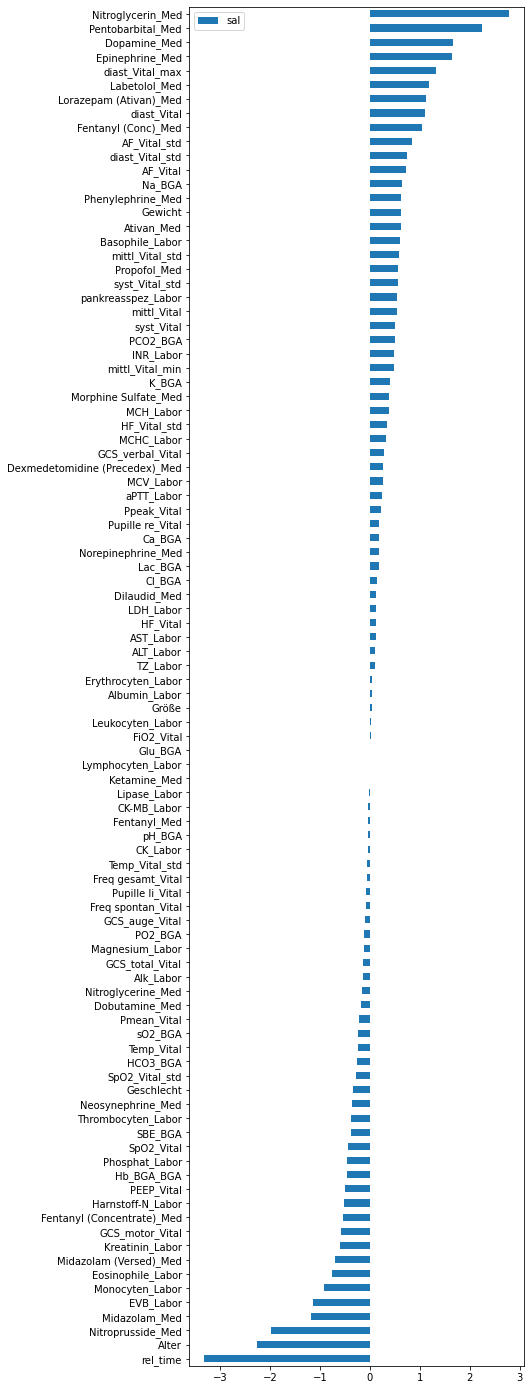

In [27]:
plt.figure()
p = feat_sal_df.plot.barh(figsize = (6, 25))

In [28]:
p.figure.savefig("importances.jpg", bbox_inches='tight')

In [29]:
plt.show()

In [30]:
sal_list[0].shape

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
len(feature_names)

92

In [ ]:
sal = sal_list[0]

all_steps = []
for i, s in enumerate(sal):
    pat_df = pd.DataFrame(s, columns=feature_names)
    pat_df["pat_id"] = i
    pat_df["step"] = np.arange(s.shape[0])
    all_steps.append(pat_df)
sal_df = pd.concat(all_steps, axis=0)

In [ ]:
# kick out pats with less than 4 measurements
sal_df_min_four = sal_df[sal_df.groupby("pat_id").step.transform(len) >= 4]
# calculate N averaged steps per patient
N = 4
averaged_df = []
for pat_id in sal_df_min_four.pat_id.unique():
    pat_df = sal_df_min_four[sal_df_min_four.pat_id == pat_id]
    parts = np.array_split(pat_df, N)
    for part in parts:
        averaged_df.append(part.mean())
averaged_df = pd.DataFrame(averaged_df)

In [ ]:
# train umap on averaged steps
from umap import UMAP
umapper = UMAP(n_neighbors=10, min_dist=0.1)
sal_data = averaged_df.drop(columns=["pat_id", "step"])
umap_embedding = umapper.fit_transform(sal_data)

<AxesSubplot:>

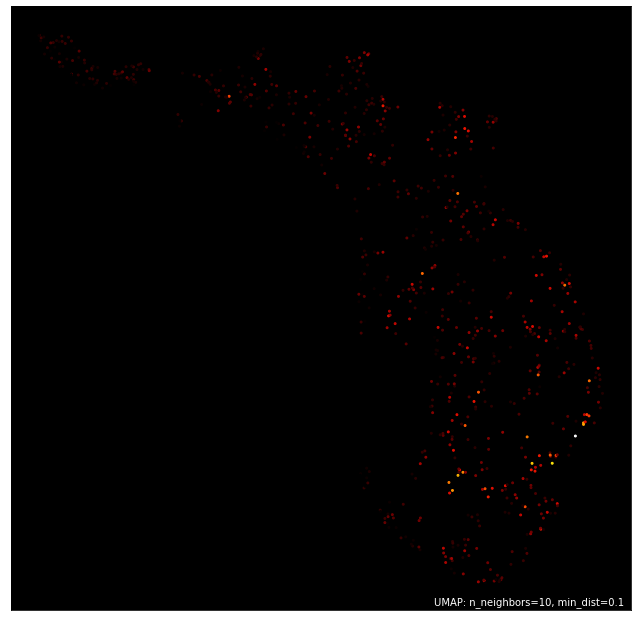

In [ ]:
# plot umap
import umap.plot
#umap.plot.points(umapper, labels=averaged_df.pat_id)
umap.plot.points(umapper, values=averaged_df.step, theme="fire")

In [ ]:
# cluster averaged using K-means
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=0)
#clustering_data = sal_data
clustering_data = umap.UMAP(n_neighbors=10, min_dist=0.1).fit_transform(sal_data)
kmeans.fit(clustering_data)
cluster_labels = kmeans.labels_

(array([157.,   0., 170.,   0.,   0.,  88.,   0., 157.,   0., 180.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

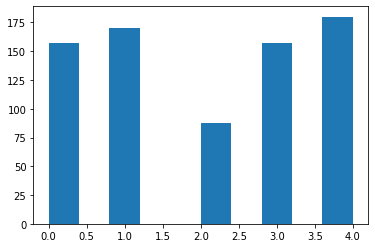

In [ ]:
# label histogram
plt.figure()
plt.hist(cluster_labels, bins=10)

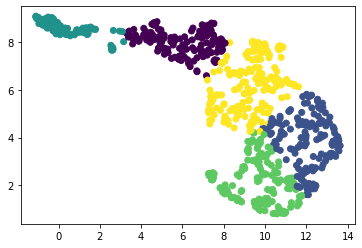

In [ ]:
# plot clusters
plt.figure()
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=cluster_labels)

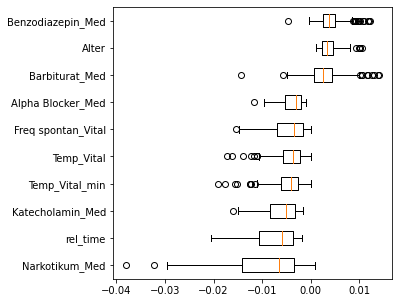

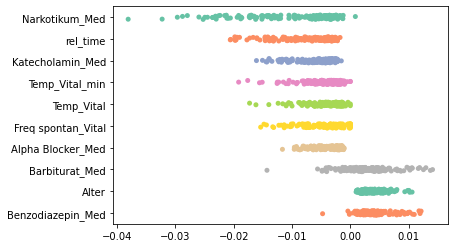

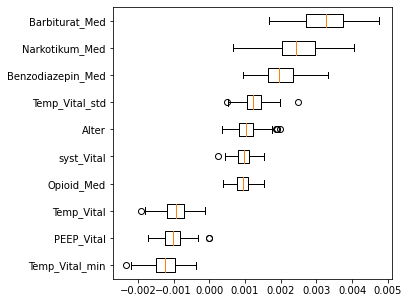

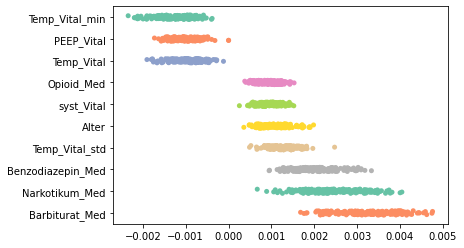

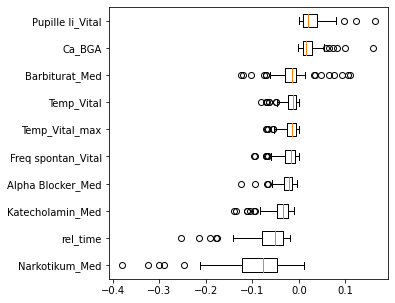

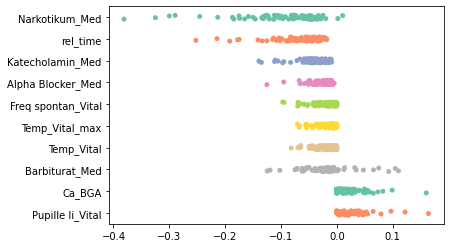

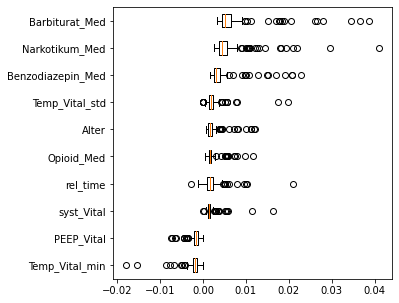

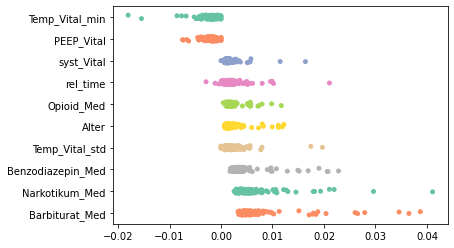

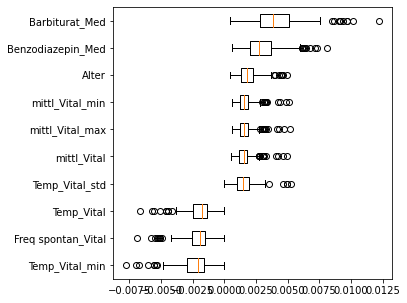

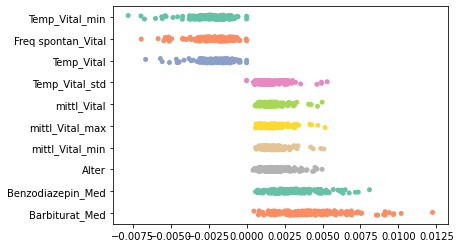

In [ ]:
# print boxplot for each feature per clusters
for i in range(np.max(cluster_labels) + 1):
    cluster_data = sal_data[cluster_labels == i]
    # sort feature columns by absolute value
    mean_abs = cluster_data.abs().mean(axis=0)
    sorted_data = sorted(cluster_data.transpose().values, key=lambda x: np.abs(x).mean())
    sorted_columns = sorted(cluster_data.columns, key=lambda x: np.abs(cluster_data[x]).mean())
    # only show top N
    N = 10
    sorted_data = sorted_data[-N:] 
    sorted_columns = sorted_columns[-N:]
    
    # now sort by mean value without abs
    mean_data = cluster_data.mean(axis=0)
    sorted_data = sorted(sorted_data, key=lambda x: x.mean())
    sorted_columns = sorted(sorted_columns, key=lambda x: mean_data[x])
    
    # show boxplot where the feature name is at the y-axis
    plt.figure(figsize=(5, 5))
    plt.boxplot(sorted_data, labels=sorted_columns, whis=1.5, vert=False)
    plt.show()
    # show variant where each single point is shown
    #plt.figure(figsize=(5, 5))
    #plt.scatter(cluster_data.index, cluster_data[sorted_columns[0]], c=cluster_labels)
    sorted_df = pd.DataFrame(sorted_data, index=sorted_columns)
    
    sns.stripplot(data=sorted_df.transpose(), orient="h", palette="Set2", color=".25")
    plt.show()
    

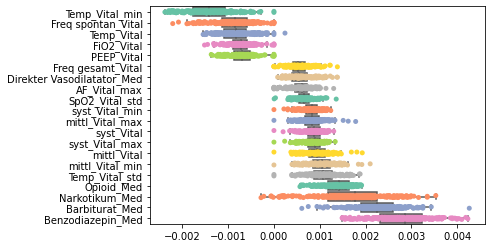

In [ ]:
sns.stripplot(data=sorted_df.transpose(), orient="h", palette="Set2", color=".25")
sns.boxplot(data=sorted_df.transpose(), orient="h", palette="Set2", showfliers=False)
plt.show()

# Tuning

In [ ]:
from tune_utils import tune#, make_tune_plots
from data_utils import make_split

import importlib
import tune_utils
importlib.reload(tune_utils)
from tune_utils import tune

import data_utils
importlib.reload(data_utils)

ImportError: cannot import name 'tune' from 'tune_utils' (/home/anton/ICU/icp_prediction/tune_utils.py)

In [ ]:
import logging
import pytorch_lightning

logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
logging.getLogger("lightning").setLevel(logging.ERROR)
pytorch_lightning.utilities.distributed.log.setLevel(logging.ERROR)

In [ ]:
cfg["dbs"] = ["UKE"]
cfg["k_fold"] = 0
cfg["num_splits"] = 3
cfg["flat_block_size"] = 0
cfg["n_trials"] = 15
cfg["model_type"] = "linear"
cfg["fill_type"] = "pat_mean"

cfg["max_steps"] = 300

opt_flat_block_size = False
opt_augs = False
opt_fill_type = False

In [ ]:
#storage = optuna.storages.RDBStorage(url="sqlite:///optuna.db",
#                                         engine_kwargs={"connect_args": {"timeout": 30}})
#load_study = optuna.load_study("09_17_02_39__linear_UKE_15", storage=storage)

In [ ]:
# make dev/test split to test tuning
dev_data, test_data, dev_idcs, test_idcs = make_split(seq_list, test_size=0.2)

In [ ]:
# tune
study = tune(dev_data, test_data, args, cfg, verbose=False, n_trials=cfg["n_trials"],
             opt_flat_block_size=opt_flat_block_size, opt_augs=opt_augs, opt_fill_type=opt_fill_type)

In [ ]:
#test_idcs = np.load("test_tune/09_17_02_39__linear_UKE_15/test_idcs.npy")

In [ ]:
# print key study parts
name = study.study_name
print(name)
print(study.best_trial)
best_params = study.best_params
print(best_params)

In [ ]:
from tune_utils import store_study_results
store_study_results(study, "./test_tune/", test_idcs, args)

In [ ]:
make_tune_plots(study, f"outputs/tune_results/{cfg['model_type']}_{cfg['n_trials']}")

In [ ]:
# retrain on dev/test and check performance
    
models, trainers = retrain(dev_data, test_data, best_params, args, cfg, verbose=True)

In [ ]:
cfg["k_fold"] = 0
cfg["num_splits"] = 5
models, trainers = retrain(dev_data, test_data, best_params, args, cfg, verbose=True)

In [ ]:
cfg["k_fold"] = 5
models, trainers = retrain(dev_data, test_data, best_params, args, cfg, verbose=True)

## Nested k-fold

In [ ]:
classical_models = ["xgb", "rf", "linear"]

In [ ]:
cfg["dbs"] = ["UKE"]
cfg["k_fold"] = 0
cfg["num_splits"] = 3
cfg["flat_block_size"] = 1
cfg["n_trials"] = 10

cfg["n_outer_folds"] = 3

cfg["model_type"] = "xgb"
cfg["fill_type"] = "pat_mean"

In [ ]:
from data_utils import make_fold
# outer fold
dev_data_list, test_data_list, dev_idcs, test_idcs = make_fold(seq_list, k=cfg["n_outer_folds"])

In [ ]:
# tune and store studies
studies = []
for dev_data, test_data in zip(dev_data_list, test_data_list):
    study = tune(dev_data, test_data, args, cfg, verbose=False, n_trials=cfg["n_trials"])
    # print key tune details
    name = study.study_name
    print(name)
    print(study.best_trial)
    best_params = study.best_params
    print(best_params)
    studies.append(study)

In [ ]:
metrics = []
pred_dfs = []
for tune_idx in tqdm(range(len(studies))):
    models, trainers = retrain(dev_data_list[tune_idx],
                               test_data_list[tune_idx], 
                               studies[tune_idx].best_params, 
                               args, cfg, verbose=False)
    df = get_all_dfs(models, trainers, cfg["model_type"], dl_type="test")
    #loss = print_all_metrics(df)
    loss = df.groupby("model_id").apply(lambda model_df: model_df.groupby("ids").mean()).mean()["error"]
    metrics.append(loss)
    pred_dfs.append(df)
    print(loss)

In [ ]:
print(np.mean(metrics))
print(np.std(metrics))

In [ ]:
for study in studies:
    print(study.best_value)
    print(study.best_params)
    print()

In [ ]:
[study.best_value for study in studies]

In [ ]:
metrics

In [ ]:
print(np.mean(metrics))
print(np.std(metrics))

In [ ]:
for study in studies:
    print(study.best_value)
    print(study.best_params)
    print()

In [ ]:
metrics

In [ ]:
len(studies)

In [ ]:
studies[0].best_trial